<a href="https://colab.research.google.com/github/monokim/BERT/blob/master/Intent_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Check If there is a GPU available.

In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print(torch.cuda.get_device_name(0), 'will be used.')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
GeForce GTX 1060 will be used.


Select Bert Model

In [2]:
bert_model = 'xlnet' # bert, albert, roberta

IMDB Movie review Dataset

In [3]:

import pandas as pd

# Load the data set into a pandas dataframe
df = pd.read_csv("./Dataset/IMDB_Dataset.csv", delimiter=',', header=None, names=['review', 'sentiment'])

# Print number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
labels = df.sentiment.values[1000:5000]
labels = [1 if l == 'positive' else 0 for l in labels]
sentences = df.review.values[1000:5000]
if bert_model == 'xlnet':
    sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

print(sentences[:3])
print(labels[:3])


Number of training sentences: 50,001

["This is like a zoology textbook, given that its depiction of animals is so accurate. However, here are a few details that appear to have been slightly modified during the transition to film:<br /><br />- Handgun bullets never hit giant Komodo dragons. It doesn't matter how many times you shoot at the Komodo, bullets just won't go near it.<br /><br />- The best way to avoid being eaten by a giant Cobra, or a giant Komodo dragon, is just to stand there. The exception to this rule is if you've been told to stay very still, in which case you should run off, until the Komodo is right next to you, and then you should stand there, expecting defeat.<br /><br />- Minutes of choppy slow motion footage behind the credits really makes for enjoyable watching.<br /><br />- $5,000 is a memory enhancement tool, and an ample substitute for losing your boating license/getting arrested.<br /><br />- Members of elite army units don't see giant Komodo dragons coming 

AG NEWS Dataset

In [4]:
"""
import pandas as pd

# Load the data set into a pandas dataframe
df = pd.read_csv("./Dataset/ag_news_train.csv", delimiter=',', header=None, names=['category', "head", 'content'])

# Print number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
labels = df.category.values - 1
sentences = df.content.values
if bert_model == 'xlnet':
    sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

print(sentences[:3])
print(labels[:3])
"""

'\nimport pandas as pd\n\n# Load the data set into a pandas dataframe\ndf = pd.read_csv("./Dataset/ag_news_train.csv", delimiter=\',\', header=None, names=[\'category\', "head", \'content\'])\n\n# Print number of sentences.\nprint(\'Number of training sentences: {:,}\n\'.format(df.shape[0]))\nlabels = df.category.values - 1\nsentences = df.content.values\nif bert_model == \'xlnet\':\n    sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]\n\nprint(sentences[:3])\nprint(labels[:3])\n'

# BERT Tokenizer

Tokenize each words and convert to token IDs

In [5]:
# Install transformers by using pip
!pip install transformers

In [6]:
from transformers import BertTokenizer
from transformers import AlbertTokenizer
from transformers import RobertaTokenizer
from transformers import XLNetTokenizer

# Load BERT Tokenizer
if bert_model == 'bert':
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
elif bert_model == 'albert':
    tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
elif bert_model == 'roberta':
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
elif bert_model == 'xlnet':
    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

print('Original : ', sentences[0])
print('Tokenized : ', tokenizer.tokenize(sentences[0]))
print('Token IDs : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original :  This is like a zoology textbook, given that its depiction of animals is so accurate. However, here are a few details that appear to have been slightly modified during the transition to film:<br /><br />- Handgun bullets never hit giant Komodo dragons. It doesn't matter how many times you shoot at the Komodo, bullets just won't go near it.<br /><br />- The best way to avoid being eaten by a giant Cobra, or a giant Komodo dragon, is just to stand there. The exception to this rule is if you've been told to stay very still, in which case you should run off, until the Komodo is right next to you, and then you should stand there, expecting defeat.<br /><br />- Minutes of choppy slow motion footage behind the credits really makes for enjoyable watching.<br /><br />- $5,000 is a memory enhancement tool, and an ample substitute for losing your boating license/getting arrested.<br /><br />- Members of elite army units don't see giant Komodo dragons coming until they are within one me

Tokenized :  ['▁this', '▁is', '▁like', '▁a', '▁', 'zo', 'ology', '▁textbook', ',', '▁given', '▁that', '▁its', '▁depiction', '▁of', '▁animals', '▁is', '▁so', '▁accurate', '.', '▁however', ',', '▁here', '▁are', '▁a', '▁few', '▁details', '▁that', '▁appear', '▁to', '▁have', '▁been', '▁slightly', '▁modified', '▁during', '▁the', '▁transition', '▁to', '▁film', ':', '<', 'br', '▁', '/', '>', '<', 'br', '▁', '/', '>', '-', '▁handgun', '▁bullets', '▁never', '▁hit', '▁giant', '▁', 'kom', 'odo', '▁dragon', 's', '.', '▁it', '▁doesn', "'", 't', '▁matter', '▁how', '▁many', '▁times', '▁you', '▁shoot', '▁at', '▁the', '▁', 'kom', 'odo', ',', '▁bullets', '▁just', '▁won', "'", 't', '▁go', '▁near', '▁it', '.', '<', 'br', '▁', '/', '>', '<', 'br', '▁', '/', '>', '-', '▁the', '▁best', '▁way', '▁to', '▁avoid', '▁being', '▁eaten', '▁by', '▁a', '▁giant', '▁co', 'bra', ',', '▁or', '▁a', '▁giant', '▁', 'kom', 'odo', '▁dragon', ',', '▁is', '▁just', '▁to', '▁stand', '▁there', '.', '▁the', '▁exception', '▁to', '▁thi

Token IDs :  [52, 27, 115, 24, 17, 3929, 2666, 21704, 19, 502, 29, 81, 19530, 20, 2609, 27, 102, 4668, 9, 634, 19, 193, 41, 24, 274, 1312, 29, 1734, 22, 47, 72, 2245, 6832, 181, 18, 4251, 22, 468, 60, 6461, 2369, 17, 167, 3151, 6461, 2369, 17, 167, 3151, 13, 22008, 12318, 287, 645, 2934, 17, 20964, 12200, 8984, 23, 9, 36, 855, 26, 46, 918, 160, 142, 537, 44, 5366, 38, 18, 17, 20964, 12200, 19, 12318, 125, 282, 26, 46, 216, 479, 36, 9, 6461, 2369, 17, 167, 3151, 6461, 2369, 17, 167, 3151, 13, 18, 252, 162, 22, 1685, 163, 12434, 37, 24, 2934, 830, 3890, 19, 49, 24, 2934, 17, 20964, 12200, 8984, 19, 27, 125, 22, 1434, 105, 9, 18, 5712, 22, 52, 1614, 27, 108, 44, 26, 189, 72, 258, 22, 1078, 172, 194, 19, 25, 59, 363, 44, 170, 446, 177, 19, 259, 18, 17, 20964, 12200, 27, 203, 244, 22, 44, 19, 21, 137, 44, 170, 1434, 105, 19, 7364, 2744, 9, 6461, 2369, 17, 167, 3151, 6461, 2369, 17, 167, 3151, 13, 641, 20, 15981, 4546, 2208, 2974, 8803, 583, 18, 7095, 343, 862, 28, 14896, 2441, 9, 6461, 2369

Sentence to ID

In [7]:
input_ids = []

for s in sentences:
    encoded_sentence = tokenizer.encode(s, max_length = 512, add_special_tokens=True)
    input_ids.append(encoded_sentence)
    
print('original: ', sentences[0])
print('id: ', input_ids[0])
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

original:  This is like a zoology textbook, given that its depiction of animals is so accurate. However, here are a few details that appear to have been slightly modified during the transition to film:<br /><br />- Handgun bullets never hit giant Komodo dragons. It doesn't matter how many times you shoot at the Komodo, bullets just won't go near it.<br /><br />- The best way to avoid being eaten by a giant Cobra, or a giant Komodo dragon, is just to stand there. The exception to this rule is if you've been told to stay very still, in which case you should run off, until the Komodo is right next to you, and then you should stand there, expecting defeat.<br /><br />- Minutes of choppy slow motion footage behind the credits really makes for enjoyable watching.<br /><br />- $5,000 is a memory enhancement tool, and an ample substitute for losing your boating license/getting arrested.<br /><br />- Members of elite army units don't see giant Komodo dragons coming until they are within one met

Add padding and attention masks

In [8]:
def add_padding_and_truncate(input_ids):
    MAX_LEN = 64
    for index, input_id in enumerate(input_ids):
        for i in range(MAX_LEN - len(input_id)):
          input_id.insert(0, 0)
        if len(input_id) > MAX_LEN:
          input_ids[index] = input_id[:MAX_LEN]


In [9]:
# Fit sentence's length to MAX_LEN
add_padding_and_truncate(input_ids)

print('After max question length: ', max([len(id) for id in input_ids]))

attention_masks = []

for id in input_ids:
    att_mask = [int(token_id > 0) for token_id in id]
    attention_masks.append(att_mask)

After max question length:  64


In [10]:
from sklearn.model_selection import train_test_split

train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)
train_masks, valid_masks, _, _ = train_test_split(attention_masks, labels, random_state=2020, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
valid_inputs = torch.tensor(valid_inputs)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

train_masks = torch.tensor(train_masks)
valid_masks = torch.tensor(valid_masks)

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = RandomSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

# Training

BertForSequenceClassification

In [12]:
from transformers import BertForSequenceClassification, BertConfig
from transformers import AlbertForSequenceClassification, AlbertConfig
from transformers import RobertaForSequenceClassification, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetConfig

num_label = 2 # depends on data.

if bert_model == 'bert':
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels = num_label, 
        output_attentions = False,
        output_hidden_states = False
    )
elif bert_model == 'albert':
    model = AlbertForSequenceClassification.from_pretrained(
        'albert-base-v2',
        num_labels = num_label,
        output_attentions = False,
        output_hidden_states = False
    )
elif bert_model == 'roberta':
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels = num_label,
        output_attentions = False,
        output_hidden_states = False
    )
elif bert_model == 'xlnet':
    model = XLNetForSequenceClassification.from_pretrained(
        'xlnet-base-cased',
        num_labels = num_label,
    )

if device.type == 'cuda':
  model.cuda()

In [13]:
from transformers import get_linear_schedule_with_warmup, AdamW

optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [14]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
import random


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...


C:\Users\mingo\Anaconda3\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  Batch    40  of    113.    Elapsed: 0:00:36.
  Batch    80  of    113.    Elapsed: 0:01:12.

  Average training loss: 0.52
  Training epcoh took: 0:01:41

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:36.
  Batch    80  of    113.    Elapsed: 0:01:12.

  Average training loss: 0.33
  Training epcoh took: 0:01:43

Running Validation...
  Accuracy: 0.84
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:38.
  Batch    80  of    113.    Elapsed: 0:01:16.

  Average training loss: 0.21
  Training epcoh took: 0:01:48

Running Validation...
  Accuracy: 0.84
  Validation took: 0:00:04

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:38.
  Batch    80  of    113.    Elapsed: 0:01:17.

  Average training loss: 0.14
  Training epcoh took: 0:01:48

Running Validation...
  Accuracy: 0.85
  Vali

Plot

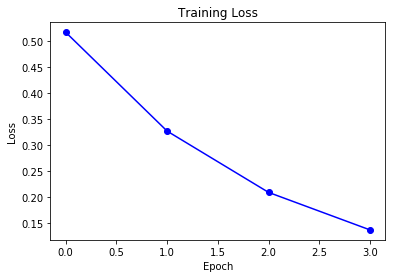

In [20]:
import matplotlib.pyplot as plt

plt.plot(loss_values, 'b-o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# test

In [19]:
import pandas as pd

df = pd.read_csv("./Dataset/IMDB_Dataset.csv", delimiter=',', header=None, names=['review', 'sentiment'])
sentences = df.review.values[1:1000]
labels = df.sentiment.values[1:1000]
labels = [1 if l == 'positive' else 0 for l in labels]

"""
df = pd.read_csv("./Dataset/ag_news_test.csv", delimiter=',', header=None, names=['category', "head", 'content'])

# Print number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
sentences = df.content.values
labels = df.category.values - 1
"""

if bert_model == 'xlnet':
    sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

input_ids = []

for s in sentences:
    encoded_sentence = tokenizer.encode(s, max_length = 512, add_special_tokens=True)
    input_ids.append(encoded_sentence)
        
add_padding_and_truncate(input_ids)

attention_masks = []

for id in input_ids:
    att_mask = [int(token_id > 0) for token_id in id]
    attention_masks.append(att_mask)
    
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

model.eval()

eval_accuracy = 0
eval_steps = 0
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    #predictions.append(logits)
    #true_labels.append(label_ids)
    
    eval_accuracy += flat_accuracy(logits, label_ids)
    eval_steps += 1

print("Accuracy: {0:.3f}".format(eval_accuracy/eval_steps))
print("Done")

C:\Users\mingo\Anaconda3\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy: 0.831
Done
